# Homework 7 (50 points)

In this Homework, we will try to classify observations of space to be either stars, galaxies or quasars based on the RD14 from the Sloan Digital Sky Survey  (SDSS). The Sloan Digital Sky Survey is a project which offers public data of space observations. Observations have been made since 1998 and have been made accessible to everyone who is interested. 

http://www.sdss.org/
![alt text](http://www.fingerprintdigitalmedia.com/wp-content/uploads/2014/08/sdss1.jpg)

For this purpose a special 2.5 m diameter telescope was built at the Apache Point Observatory in New Mexico, USA. The telescope uses a camera of 30 CCD-Chips with 2048x2048 image points each. The chips are ordered in 5 rows with 6 chips in each row. Each row observes the space through different optical filters (u, g, r, i, z) at wavelengths of approximately 354, 476, 628, 769, 925 nm.


In this homework we will train several classifier to predict the class of a celestial object based on the observations (features). We will practice data prep, dimensionality reduction, model design and training, model comparison, and feature importance selection.

### Importing Libraries

In [380]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline


## 1) Data Preparation (20 points)

We follow the following steps:
* read (1 point)
* clean (3 points)
* correlate (4 points)
* explore, spread of values (3 points)
* dimensionality reduction (9 points)

### 1.1 Data read
Read the pandas fata frame from the csv file "Skyserver_SQL2_27_2018.csv" and skip the first row.

**Task: read (1 point)**

Save a copy of the data frame just in case.

In [381]:
# answer
sky_df = pd.read_csv('Skyserver_SQL2_27_2018.csv')

**Description of the data fields**

* objid = Object Identifier, self explanatory.
* ra = J2000 Right Ascension (r-band). Angular that is measured eastward along the celestial equator from the Sun at the March equinox to the hour circle of the point above the earth in question.   https://en.wikipedia.org/wiki/Right_ascension
* dec = J2000 Declination (r-band). Angle that is measured north or south of the celestial equator, along the hour circle passing through the point in question. https://en.wikipedia.org/wiki/Declination



The Gunn astronomic magnitude system. u, g, r, i, z represent the response of the 5 bands of the telescope.

Further Information: http://astroweb.case.edu/ssm/ASTR620/mags.html 
* u = better of DeV/Exp magnitude fit
* g = better of DeV/Exp magnitude fit
* r = better of DeV/Exp magnitude fit
* i = better of DeV/Exp magnitude fit
* z = better of DeV/Exp magnitude fit




Run, rerun, camcol and field are features which describe a field within an image taken by the SDSS. A field is basically a part of the entire image corresponding to 2048 by 1489 pixels. 
* run = Run Number, which identifies the specific scan. 
* rereun = Rerun Number, which specifies how the image was processed.
* camcol = Camera column, a number from 1 to 6, identifying the scanline within the run.
* field = Field number, which typically starts at 11 (after an initial rampup time), and can be as large as 800 for particularly long runs.
* specobjid = Object Identifier
* class = object class (galaxy, star or quasar object): The class identifies an object to be either a galaxy, star or quasar. This will be the response variable which we will be trying to predict.

* redshift = Final Redshift: In physics, **redshift** happens when light or other electromagnetic radiation from an object is increased in wavelength, or shifted to the red end of the spectrum. 

* plate = plate number: Each spectroscopic exposure employs a large, thin, circular metal **plate** that positions optical fibers via holes drilled at the locations of the images in the telescope focal plane. These fibers then feed into the spectrographs. Each plate has a unique serial number, which is called plate in views such as SpecObj in the CAS.

* mjd = MJD of observation, **Modified Julian Date**, used to indicate the date that a given piece of SDSS data (image or spectrum) was taken.
* fiberid = fiber ID. The SDSS spectrograph uses optical fibers to direct the light at the focal plane from individual objects to the slithead. Each object is assigned a corresponding **fiberID**. 

**Further information on SDSS images and their attributes:** 

http://www.sdss3.org/dr9/imaging/imaging_basics.php

http://www.sdss3.org/dr8/glossary.php

### 1.2 Data Cleaning 

Basic stats about our dataset. 

**Task: Provide basic infor for the pandas dataframe head (0.5 point)**

In [382]:
sky_df.head(5)

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1.237650e+18,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752,301,4,267,3.722360e+18,STAR,-0.000009,3306,54922,491
1,1.237650e+18,183.598370,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752,301,4,267,3.638140e+17,STAR,-0.000055,323,51615,541
2,1.237650e+18,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752,301,4,268,3.232740e+17,GALAXY,0.123111,287,52023,513
3,1.237650e+18,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,752,301,4,269,3.722370e+18,STAR,-0.000111,3306,54922,510
4,1.237650e+18,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,752,301,4,269,3.722370e+18,STAR,0.000590,3306,54922,512


In [383]:
sky_df.describe()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,redshift,plate,mjd,fiberid
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.0,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.237650e+18,175.529987,14.836148,18.619355,17.371931,16.840963,16.583579,16.422833,981.034800,301.0,3.648700,302.380100,1.645022e+18,0.143726,1460.986400,52943.533300,353.069400
std,0.000000e+00,47.783439,25.212207,0.828656,0.945457,1.067764,1.141805,1.203188,273.305024,0.0,1.666183,162.577763,2.013998e+18,0.388774,1788.778371,1511.150651,206.298149
min,1.237650e+18,8.235100,-5.382632,12.988970,12.799550,12.431600,11.947210,11.610410,308.000000,301.0,1.000000,11.000000,2.995780e+17,-0.004136,266.000000,51578.000000,1.000000
25%,1.237650e+18,157.370946,-0.539035,18.178035,16.815100,16.173333,15.853705,15.618285,752.000000,301.0,2.000000,184.000000,3.389248e+17,0.000081,301.000000,51900.000000,186.750000
50%,1.237650e+18,180.394514,0.404166,18.853095,17.495135,16.858770,16.554985,16.389945,756.000000,301.0,4.000000,299.000000,4.966580e+17,0.042591,441.000000,51997.000000,351.000000
75%,1.237650e+18,201.547279,35.649397,19.259232,18.010145,17.512675,17.258550,17.141447,1331.000000,301.0,5.000000,414.000000,2.881300e+18,0.092579,2559.000000,54468.000000,510.000000
max,1.237650e+18,260.884382,68.542265,19.599900,19.918970,24.802040,28.179630,22.833060,1412.000000,301.0,6.000000,768.000000,9.468830e+18,5.353854,8410.000000,57481.000000,1000.000000


In [384]:
# Finding if there are any zeros
columns = sky_df.columns
for i in columns:
    print(str(i), (sky_df[i] == 0).sum())

objid 0
ra 0
dec 0
u 0
g 0
r 0
i 0
z 0
run 0
rerun 0
camcol 0
field 0
specobjid 0
class 0
redshift 19
plate 0
mjd 0
fiberid 0


**Task: Find the data types of the database (floats, string, etc etc) using the ``info()`` function (0.5 point).**

In [385]:
# information
sky_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   objid      10000 non-null  float64
 1   ra         10000 non-null  float64
 2   dec        10000 non-null  float64
 3   u          10000 non-null  float64
 4   g          10000 non-null  float64
 5   r          10000 non-null  float64
 6   i          10000 non-null  float64
 7   z          10000 non-null  float64
 8   run        10000 non-null  int64  
 9   rerun      10000 non-null  int64  
 10  camcol     10000 non-null  int64  
 11  field      10000 non-null  int64  
 12  specobjid  10000 non-null  float64
 13  class      10000 non-null  object 
 14  redshift   10000 non-null  float64
 15  plate      10000 non-null  int64  
 16  mjd        10000 non-null  int64  
 17  fiberid    10000 non-null  int64  
dtypes: float64(10), int64(7), object(1)
memory usage: 1.4+ MB


Are there any obvious feature (or element of the dataframe) that should not impact our prediction?
 
**objid** and **specobjid** are just identifiers for accessing the rows back when they were stored in the original databank. Therefore we will not need them for classification as they are not related to the outcome.
The features **run**, **rerun**, **camcol** and **field** are values which describe parts of the camera at the moment when making the observation, e.g. 'run' represents the corresponding scan which captured the oject.

Source: http://www.sdss3.org/dr9/imaging/imaging_basics.php

**Task: Drop these columns in the pandas dataframe. (1 point)**

In [386]:
# answer
sky_df.drop(columns=['objid', 'specobjid'], inplace=True)

Find our how many examples there are, how many attributes or feature, and the type of class.

In [387]:
# description
# We have 15 features

#Their types of class are integers

print(sky_df.info())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ra        10000 non-null  float64
 1   dec       10000 non-null  float64
 2   u         10000 non-null  float64
 3   g         10000 non-null  float64
 4   r         10000 non-null  float64
 5   i         10000 non-null  float64
 6   z         10000 non-null  float64
 7   run       10000 non-null  int64  
 8   rerun     10000 non-null  int64  
 9   camcol    10000 non-null  int64  
 10  field     10000 non-null  int64  
 11  class     10000 non-null  object 
 12  redshift  10000 non-null  float64
 13  plate     10000 non-null  int64  
 14  mjd       10000 non-null  int64  
 15  fiberid   10000 non-null  int64  
dtypes: float64(8), int64(7), object(1)
memory usage: 1.2+ MB
None


In [388]:
# description
# We have 1 label being class 

#Their types of class are integers

print(sky_df[['class']].info())




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   class   10000 non-null  object
dtypes: object(1)
memory usage: 78.2+ KB
None


**Task: How many objects are in each class? (1 point)**

In [389]:
# Count the elements in each class
print('There are',len(sky_df['class']), ' total objects in each class')

classes = sky_df['class'].unique()
for i in classes:
    print(i,len(sky_df[sky_df['class'] == i]))

There are 10000  total objects in each class
STAR 4152
GALAXY 4998
QSO 850


The classes are "GALAXY", "STAR", and "QSO" (quasars). They are defined as strings, but we will convert them to integer in order to apply a loss function on the class labels during training. For this, we use the ``sklearn.preprocessing.LabelEncoder()`` function. We will do so and modify the classes in the dataframe. We should keep a copy of the original data frame to be safe.

In [390]:
sdss_df_save = sky_df # make a copy of the original data before cleaning it. That works well when the data is small.

# encode class labels to integers
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(sky_df['class'])
sky_df['class'] = y_encoded
#  GALAXY = 0
# STAR = 1
# QSO = 2

### 1.3 Data correlations
Now let's find the most basic correlations among features. This can be done using the ``corr()`` function to apply on the pandas dataframe. Evaluate this function and comment on what feature is correlated among others. It is convenient to use the matplotlib function ``matshow()`` for clarity. ``seaborn`` is a python module that makes really pretty statistical plots https://seaborn.pydata.org/index.html#. Install it with ``pip`` and import it.

In [391]:
import seaborn as sns
correlations = sky_df.drop('class',axis=1).corr()

#field and ra (negative, -0.46) are te most correlated, but still not a STRONG correlation

**Task: Plot the correlation matrix that can be called in the pandas dataframe. (2 points)**

Hints:

Use functions of ``heatmap``, add the labels in the axes. The colormap ``coolwarm`` is nice for divergent scales like correlations that vary between -1 and 1. The argument ``center=0`` ensures that the colormap is divergent from zero. Make sure to ignore the label column "class". Remember that dropping a column can be done in place ``sdss_df.drop('class', axis=1)``.

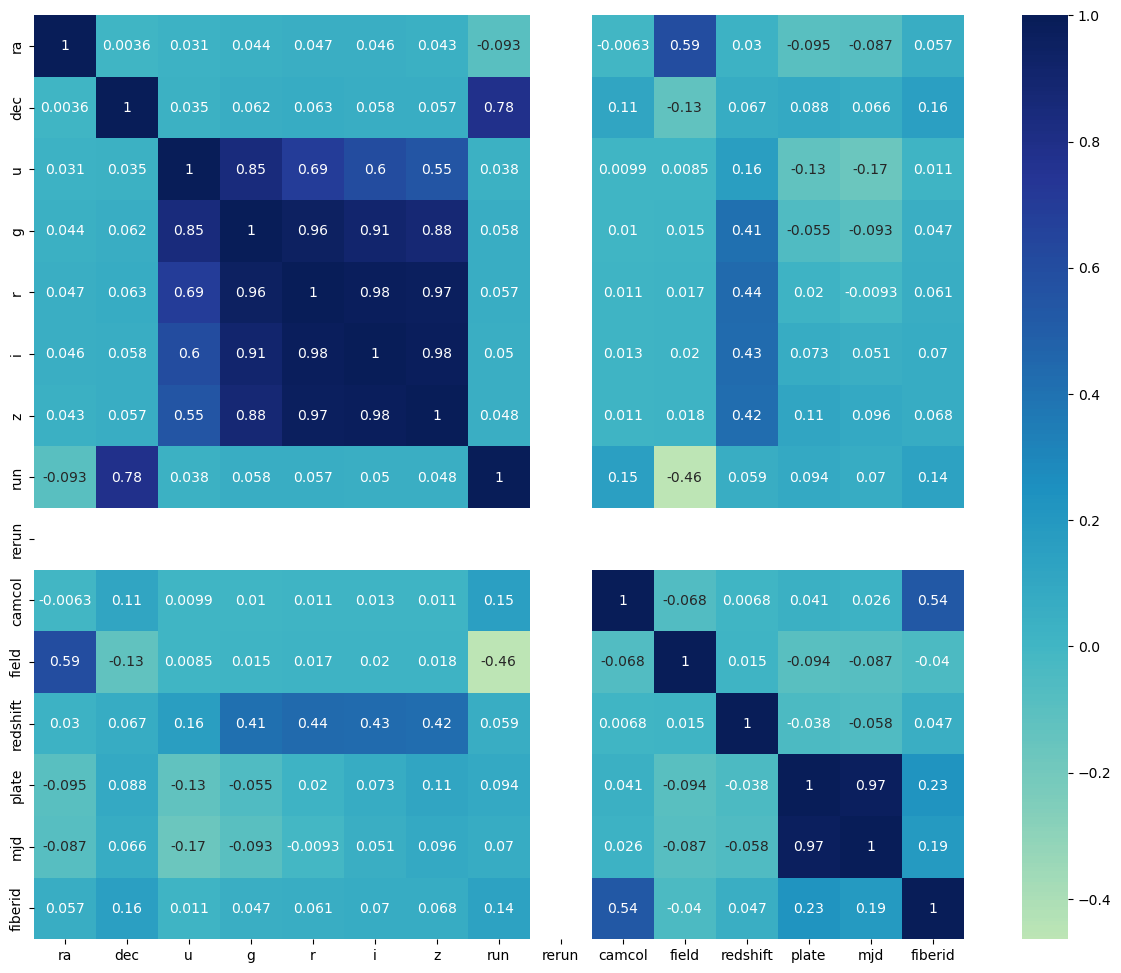

In [392]:
plt.figure(figsize=(15,12))
corrPlot = sns.heatmap(correlations,cmap='YlGnBu', annot=True, center=0)

plt.show()

**Task: Reproduce the same plot for each of the three classes. (1 point)**
You can select the values from the pandas dataframe by selecting over the column 'class'. 

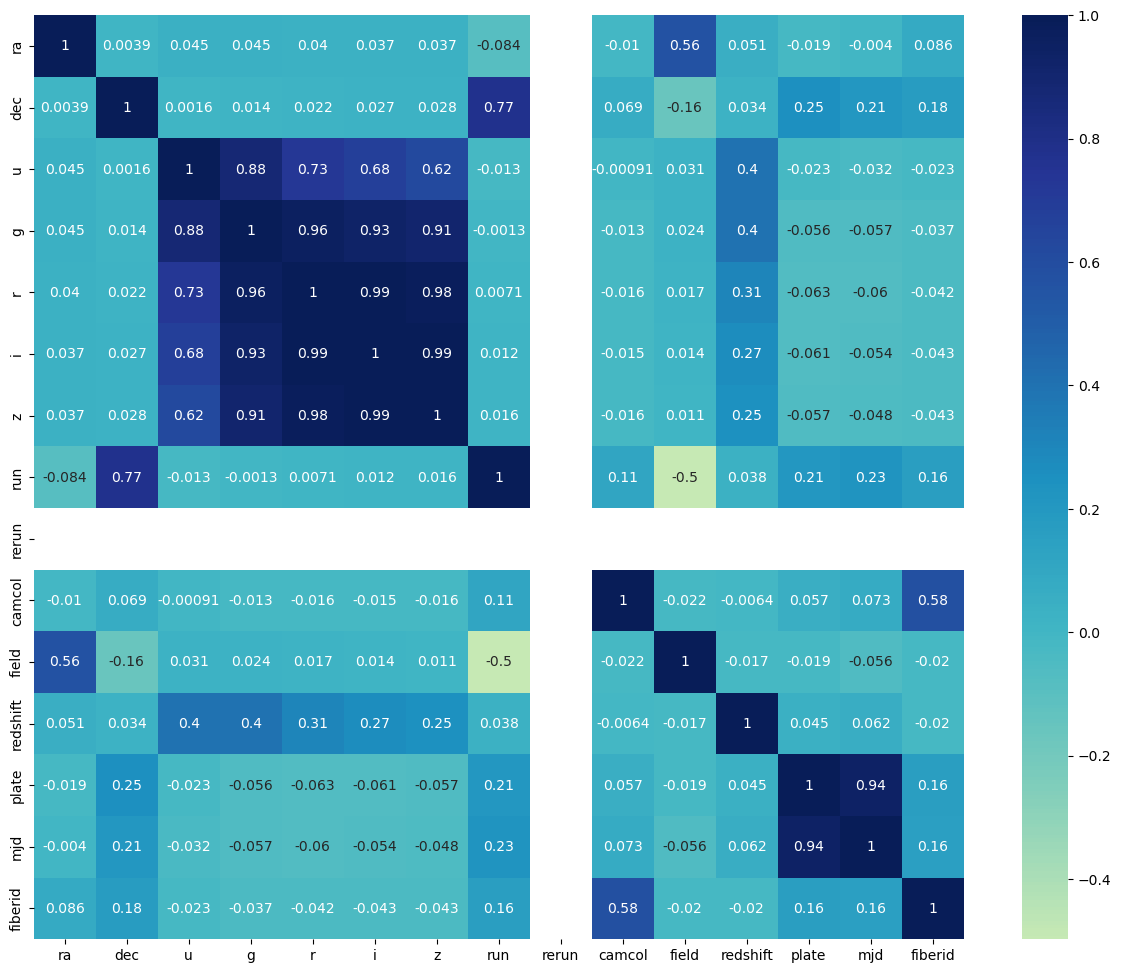

In [393]:
#  GALAXY = 0

#singing our rows only where the class is galazy (0)
galaxy = sky_df[sky_df['class']==0]

#new correlations df
correlations_galaxy = galaxy.drop('class',axis=1).corr()

#Plotting now
plt.figure(figsize=(15,12))
corrPlot = sns.heatmap(correlations_galaxy,cmap='YlGnBu', annot=True, center=0)

plt.show()

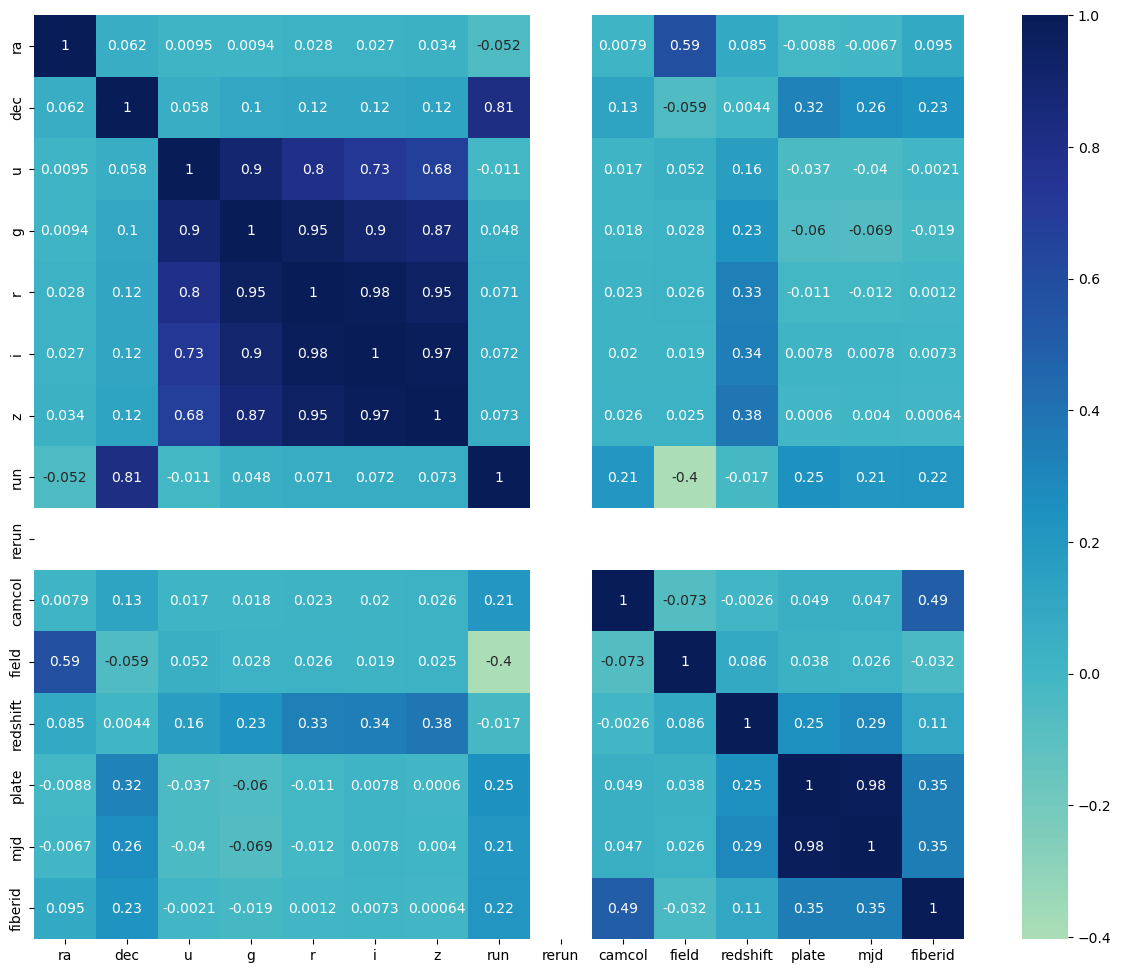

In [394]:
# STAR = 1

#singing our rows only where the class is star (1)
star = sky_df[sky_df['class']==1]

#new correlations df
correlations_star = star.drop('class',axis=1).corr()

#Plotting now
plt.figure(figsize=(15,12))
corrPlot = sns.heatmap(correlations_star,cmap='YlGnBu', annot=True, center=0)

plt.show()

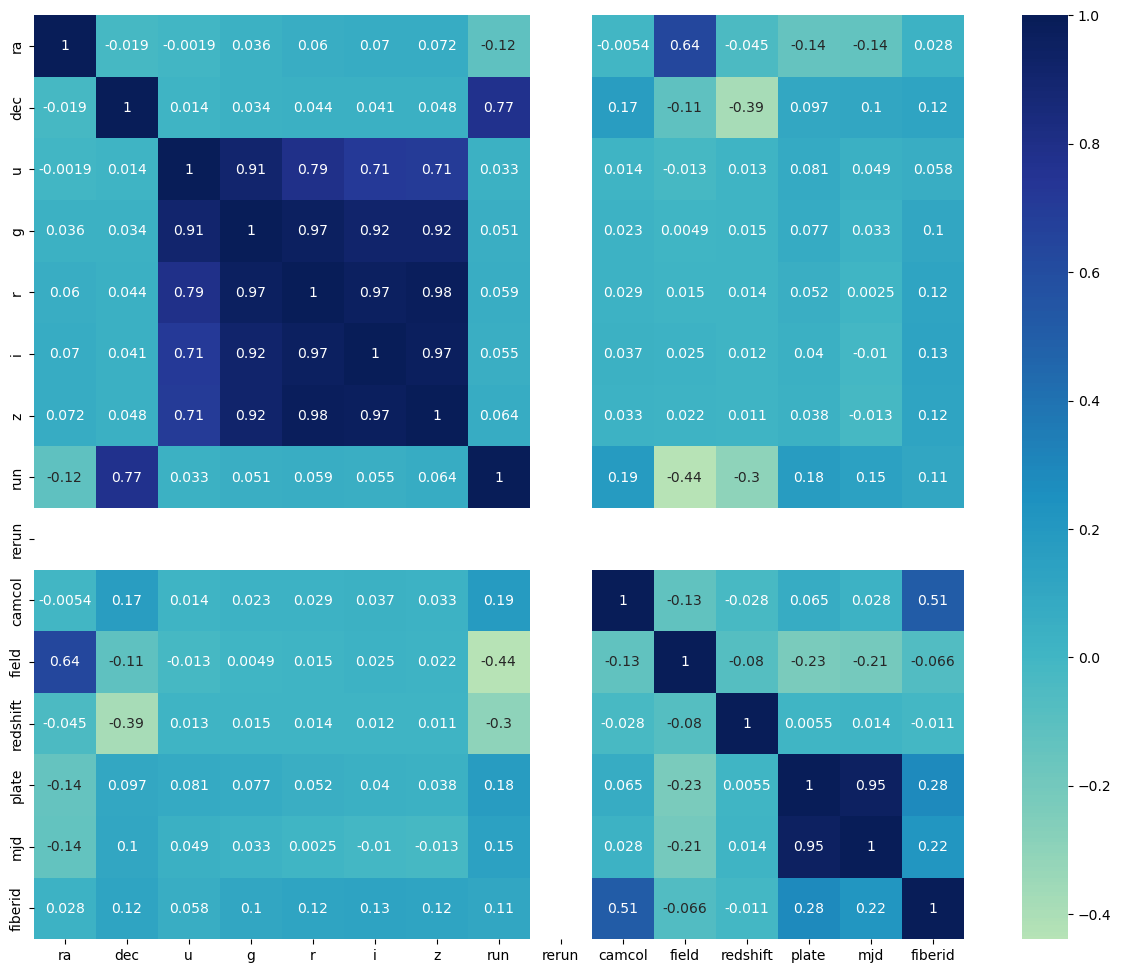

In [395]:
# QSO = 2

#singing our rows only where the class is qso (2)
qso = sky_df[sky_df['class']==2]

#new correlations df
correlations_qso = qso.drop('class',axis=1).corr()

#Plotting now
plt.figure(figsize=(15,12))
corrPlot = sns.heatmap(correlations_qso,cmap='YlGnBu', annot=True, center=0)

plt.show()

**Task: Can you comment on groups of observations that can be grouped together or that appear independent from each other given these correlations, and if there is any difference between the three celestial objects? (**1 point**)**

In the Galaxy subset there are large correlations with the letters u-z with each other along with plate and mjd.

In Star subset we see something very similar but u-z correlation with redshift is getting lower

In the Qso subset, we see something similar again exect for there are much lower correlations with the u-z with redshift.

### 1.5 Data exploration
Given the structure of the correlations, we will explore the values of the data.

#### 1.5.a. Distributions of redshift
"redshifting" happens when the source of light is becoming more distant to the receiver: the object is moving away from Earth. 

**Task: plot histograms for the 'redshift' feature column for each class (1 point).**

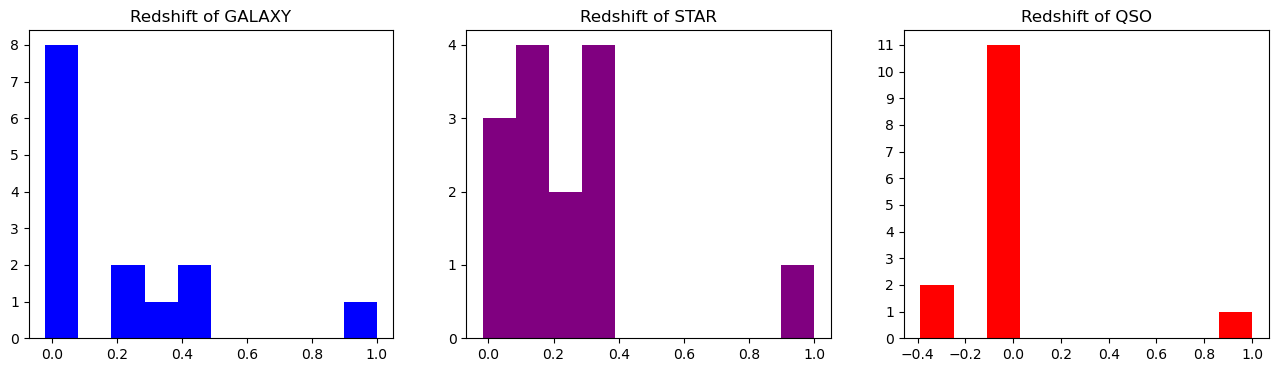

In [396]:
# answer
fig, axs = plt.subplots(nrows=1, ncols=3,figsize=(16, 4))

plt.setp(axs,
        yticks=list(range(0,12)))



axs[0].hist(correlations_galaxy['redshift'], color='blue')
axs[0].set_title('Redshift of GALAXY')

axs[1].hist(correlations_star['redshift'], color='purple')
axs[1].set_title('Redshift of STAR')

axs[2].hist(correlations_qso['redshift'], color='red', label='QSO')
axs[2].set_title('Redshift of QSO')


plt.show()

**Task : Describe briefly the difference between the three histograms. (0.5 point)**

The three histogrames show these appear to be more dispersed in GALAXY and QSO, but STAR has the highest occurance of these values, and QSO seems to occur at 0 the most of the whole dataset and has some negative and a little positive occurances.WSO has the only negative values.

<!-- # answer -->
* **Star:** The histogram looks like a truncated zero-centered normal distribution. It looks like stars are both coming toward and away from the Earth.

* **Galaxy:** The redshift values may come from a slightly right-shifted normal distribution which is centered around 0.075. It looks like galaxies are moving away from the Earth but at slow speeds.

* **QSO:** The redshift values for QSOs are a lot more uniformly distributed than for Stars or Galaxies. They are roughly evenly distributed from 0 to 3, than the occurences decrease drastically. For 4 oder ~5.5 there are some outliers. This probably means that quasards are moving away from the earth with a diverse range of speeds.


#### 1.5.b. Right ascension (ra) and declination (dec) 

We will now plot the right ascension versus the declination depending on the class. You can use the ``lmplot`` function in ``seaborn`` (https://seaborn.pydata.org/generated/seaborn.lmplot.html) to represent the sky view of these objects.

In [397]:
from seaborn import lmplot

Text(0.5, 1.0, 'Equatorial coordinates')

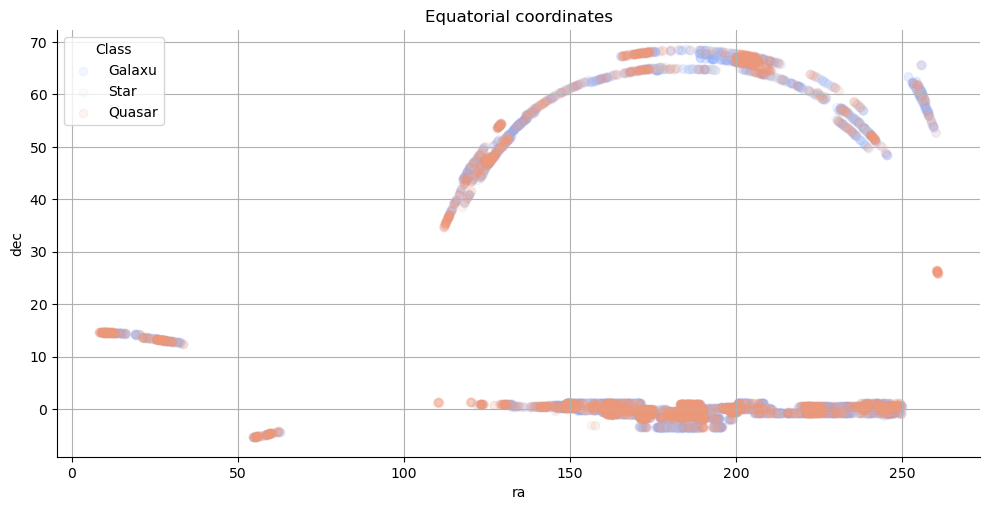

In [398]:
sns.lmplot(x='ra', y='dec', data=sky_df, hue='class', fit_reg=False, palette='coolwarm',
           scatter_kws={'alpha':0.1}, aspect=2,legend=False)

plt.legend(title='Class', loc='upper left', labels=['Galaxu', 'Star','Quasar'])
plt.grid(True)
plt.title('Equatorial coordinates')

**Task: do you see any obvious differences such that one could easily discriminate between the two coordinates? (0.5 point)**

I notice that the galaxy cordinates are more distributed than the Quasar and the Star 
features, and that galaxy mostly takes over the cra(255), dec(60) region.
But there arent really much differnces between the three classes.

#### 1.5.c Filters - u,g,r,i,z 

Recall: u, g, r, i, z represent the different wavelengths which are used to capture the observations. According to the correlation matrix, they are correlated for all three classes.

Therefore it is interesting to see that band 'u' is less correlated to the other bands. 

**Task Plot histograms and discuss why you expect these features to be correlated (1 points)**

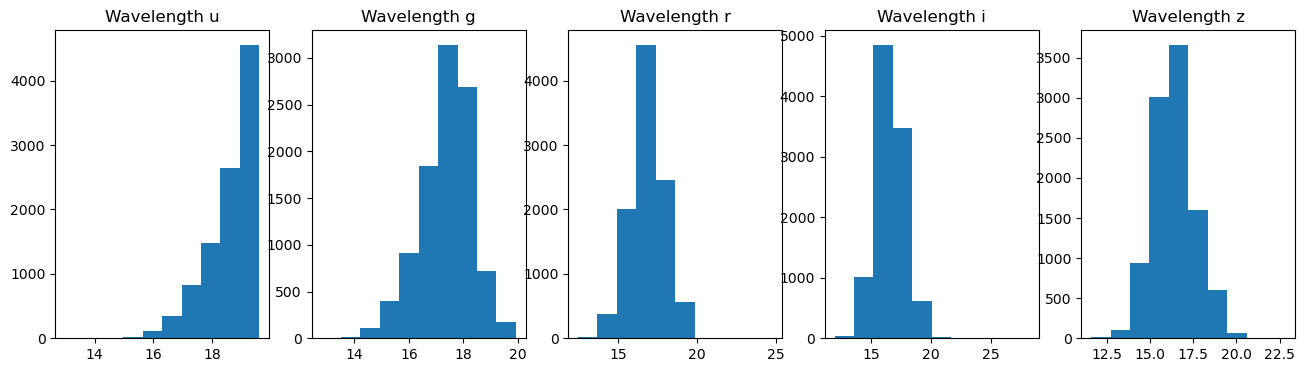

In [399]:
# Plot of histograms
import warnings
warnings.filterwarnings('ignore')

fig, axs = plt.subplots(ncols=5,figsize=(16, 4))

list_wavelength = ['u', 'g', 'r', 'i', 'z']

for i in range(0,5):
    axs[i].hist(sky_df[str(list_wavelength[i])])
    axs[i].set_title('Wavelength' + ' ' + str(list_wavelength[i]))

<!-- Anwer: -->
U may be less correlated because it has less distrubuted values than the other wavelengths. 

### 1.6 Data Dimensionality Reduction
At this point, we are left with 8 features: redshift, u, g, r, i, z, ra, and dec. Among these, the filters (u, g, r, i, z) are correlated to each other. There is therefore a potential for reducing the dimensions of the features using PCA on these 5 features.

We will use the skilearn function ``sklearn.decomposition.PCA()`` to fit and transform the data into the PC coordinates. Lets' first explore how many PCs we need. Fit the PCA function over the total number of filters. You will fit the PCA function over an array with the columns selected from the dataframe. 

**Task: Perform the PCA over a max number of PCs, output the explained variance ratio values, decide on an appropriate maximum number of PC to use (6 points)**

In [400]:
features = sky_df.iloc[:,[0,1,2,3,4,5,6]]

In [401]:

from sklearn.decomposition import PCA # this is the SKLEAN model
pca=PCA(n_components=7).fit(features.transpose())# retain all 3 components
print(pca)

PCA(n_components=7)


*Answer on how many PCs to use*



In [402]:
pca = PCA(n_components=d).fit(features)
features_pca = pca.transform(features)
print("original shape:   ", features.shape)
print("transformed shape:", features_pca.shape)

original shape:    (10000, 7)
transformed shape: (10000, 1)


In [403]:
d = np.argmax(np.cumsum(pca.explained_variance_ratio_)>=0.95) +1
print("minimum dimension size to explain 95% of the variance",d)

minimum dimension size to explain 95% of the variance 1


We will now re-perform PCA with the number of PCs you found is most appropriate. Re-apply the fit-transform function. Update the dataframe by adding the PCA value(s) and dropping the columns of the 5 filter features.

**Task: PCA again, fit and transform, update the dataframe with the new feature(s) (3 points)**

In [404]:
pca = PCA(n_components=d).fit(features)
X_pca = pca.transform(features)
print("original shape:   ", features.shape)
print("transformed shape:", X_pca.shape)

original shape:    (10000, 7)
transformed shape: (10000, 1)


In [405]:
# Find the azimuth of the displacement vector
features_new = pca.inverse_transform(features_pca)
print(features_new.shape)


(10000, 7)


## 2) Machine Learning Models (26 points)

We will now train different models on this dataset. We have a total of 8 features, 3 classes, and 10,000 samples. We will use K-Nearest Neighbors, Naive Bayes, Random Forest, Support Vector Machine, Multi Layer Perceptron.

We now follow a normal machine learning workflow:
* Feature scaling (2 points)
* Train/test set split (2 points)
* Model design, training, testing (15 points)
* Model comparisons, pick your winner, discuss feature importance using Random Forest. (10 points)

### 2.1 Feature Scaling
Scaling all values to be within the (0, 1) interval will reduce the distortion due to exceptionally high values and make some algorithms converge faster. You can scale the features only by dropping the "class" column without modifying the dataframe in place, using the pandas function ``drop()``.

**Task: Scale just the features (2 points)**

In [406]:
# answer
features = sky_df.drop('class',axis=1)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit_transform(features)# fit the model for data normalization
features = scaler.transform(features) # transform the data. watch that data was converted to a numpy array
print(type(features))
print(features)

<class 'numpy.ndarray'>
[[0.69383227 0.07402547 0.98096486 ... 0.37328094 0.56649161 0.49049049]
 [0.69409764 0.07464221 0.8582499  ... 0.00699902 0.006268   0.54054054]
 [0.69442156 0.07451911 0.96718767 ... 0.00257859 0.0753854  0.51251251]
 ...
 [0.48809742 0.77172401 0.87267752 ... 0.86407171 0.92071828 0.62162162]
 [0.48779894 0.77288846 0.89153871 ... 0.02222495 0.05065221 0.22822823]
 [0.4885425  0.77359512 0.9509842  ... 0.02222495 0.05065221 0.23223223]]


### 2.2 Test, train, validation data sets.
**Task: Split the data into a training and a test part.  (2 points)**

The models will be trained on the training data set and tested on the test data set

In [407]:
labels = np.array(sky_df['class'])

In [408]:
# answer
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)



Computation time is important to account for when scaling up the data set and the model size. You can evaluate the relative computational time using the function ``time.perf_counter()`` to evaluate the absolute time. Then compare the computational time by making the difference between two time stamps:

``t1=time.perf_counter()``

``t2=time.perf_counter()``

``tcomp = t2 - t1``

We will also assess the model performance of these multi-class classifiers. We will evaluate the average of the scores over the 3 class labels.

In [409]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from sklearn.model_selection import cross_val_predict
label_name = ['Star','Galaxy','Quasar']

In the following, we will be testing over several classifiers. Follow the steps:
1. model definition/design
2. training
3. prediction on test
4. evaluation: a) print the classification_report; b) save the precision, recall, fscore and accuracy in variables

### 2.3.a K Nearest Neighbors (3 points)
Check out the function arguments and definition here: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

In [410]:
#answer
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
print("Classifying using K-nearest Neighbors")



# K-nearest Neighbors

# model design
knn_clf = KNeighborsClassifier()
# training
knn_clf.fit(train_features, train_labels)
# evaluation on test
knn_prediction = knn_clf.predict(test_features) # predict on test
# print the classification report

report_k = classification_report(y_true=test_labels ,y_pred=knn_prediction, output_dict=True)

# save values of precision, recall, fscore, accuracy
report_k = pd.DataFrame(report).transpose()

precision_k = report_k['precision'].mean()

recall_k = report_k['recall'].mean()

fscore_k = report_k['f1-score'].mean()

accuracy_k = report_k.loc['accuracy'].mean()

Classifying using K-nearest Neighbors


### 2.3.b Naive Bayes (3 points)
Check out the sklearn tutorial pages here: https://scikit-learn.org/stable/modules/naive_bayes.html#naive-bayes. We propose to use the Gaussian Naive Bayes.

Naive Bayes assumes the data to be normally distributed which can be achieved by scaling using the MaxAbsScaler. For this example then we will use the unscaled data, then rescale it.

In [411]:
# answer
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MaxAbsScaler
print("Classifying using Gaussian Naive Bayes")

# model design
scaler_gnb = MaxAbsScaler()
# re-scale the data

sdss = scaler_gnb.fit_transform(sky_df.drop('class', axis=1))
X_train_gnb, X_test_gnb, y_train_gnb, y_test_gnb = train_test_split(sdss, sky_df['class'], test_size=0.33)

# training
gnb = GaussianNB()
training_start_time = time.perf_counter()
gnb.fit(X_train_gnb, y_train_gnb)
training_end_time = time.perf_counter()
total_training_time = training_end_time - training_start_time

# evaluation
NB_prediction = gnb.predict(X_test_gnb)

# print the classification report
report_NB = classification_report(y_true=NB_prediction ,y_pred=y_test_gnb, output_dict=True)

# save values of precision, recall, fscore, accuracy.
report_nb = pd.DataFrame(report_NB).transpose()

precision_nb = report_nb['precision'].mean()

recall_nb = report_nb['recall'].mean()

fscore_nb = report_nb['f1-score'].mean()

accuracy_nb = report_nb.loc['accuracy'].mean()
print(accuracy_nb, fscore_nb, recall_nb, precision_nb)

Classifying using Gaussian Naive Bayes
0.9715151515151516 0.955507262209209 0.9478802588806635 0.9644067697868158


### 2.3.c Random Forest Classifier (2 points)
Check out the tutorial page here: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [412]:
# answer
from sklearn.ensemble import RandomForestClassifier
print("Classifying using Random Forest Classifiers")

# model design
rf_clf = RandomForestClassifier(random_state=42, verbose=True) # model design
# training
rf_clf.fit(train_features, train_labels)
# evaluation: 
rf_prediction = rf_clf.predict(test_features)
# print the classification report
report_rf = classification_report(y_true=test_labels, y_pred=rf_prediction, output_dict=True)


# save values of precision, recall, fscore, accuracy.
report_rf = pd.DataFrame(report_rf).transpose()

precision_rf = report_rf['precision'].mean()

recall_rf = report_rf['recall'].mean()

fscore_rf = report_rf['f1-score'].mean()

accuracy_rf = report_rf.loc['accuracy'].mean()
print(accuracy_rf, fscore_rf, recall_rf, precision_rf)

Classifying using Random Forest Classifiers


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.9908 0.9869837316831109 0.9839109774811156 0.9902281977146353


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


### 2.3.d Support Vector Machine Classifier (2 points)
Check out the sklearn information page here: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC

In [457]:
# answer
from sklearn.svm import SVC
print("Classifying using Support Vector Machine Classfiers")

# model design
SVC_clf = SVC(gamma=0.001) # model design
# training
SVC_clf.fit(train_features, train_labels)
# evaluation
svc_prediction = SVC_clf.predict(test_features)
# print the classification report
report_svm = classification_report(y_true=test_labels, y_pred=svc_prediction, output_dict=True)
# save values of precision, recall, fscore, accuracy.
report_svm = pd.DataFrame(report_svm).transpose()

precision_svm = report_svm['precision'].mean()

recall_svm = report_svm['recall'].mean()

fscore_svm = report_svm['f1-score'].mean()

accuracy_svm = report_svm.loc['accuracy'].mean()
print(accuracy_svm, fscore_svm, recall_svm, precision_svm)

Classifying using Support Vector Machine Classfiers
0.7568 0.5958518783745382 0.6175381264667049 0.5978211555264308


### 2.3.e Multi-Layer Perceptron (3 points)

Check out the information page here: https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

In [458]:
# answer
from sklearn.neural_network import MLPClassifier
print("Classifying using Multi Layer Perceptron Classifier")


# model design
mlp = MLPClassifier(random_state=1, max_iter=300)
# training
mlp.fit(train_features, train_labels)

# evaluation
mlp_prediction = mlp.predict(test_features)
# print the classification report
report_mlp = classification_report(y_true=test_labels, y_pred=mlp_prediction, output_dict=True)
# save values of precision, recall, fscore, accuracy
report_mlp = pd.DataFrame(report_mlp).transpose()

precision_mlp = report_mlp['precision'].mean()

recall_mlp = report_mlp['recall'].mean()

fscore_mlp = report_mlp['f1-score'].mean()

accuracy_mlp = report_mlp.loc['accuracy'].mean()

print(accuracy_mlp, fscore_mlp, recall_mlp, precision_mlp)


Classifying using Multi Layer Perceptron Classifier
0.9792 0.9769897665426654 0.9737198925346191 0.9804931511015123


### 2.4 Model performance and comparison 

### 2.4.a Confusion Matrix and interpretation

**Task: Plot the confusion matrix (2 points)**

Use the sklearn function ``plot_confusion_matrix``. Find help here: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html. We tested 5 models, make suplots, set the title on each subplots.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


Text(0.5, 1.0, 'K-nearest Neighbors')

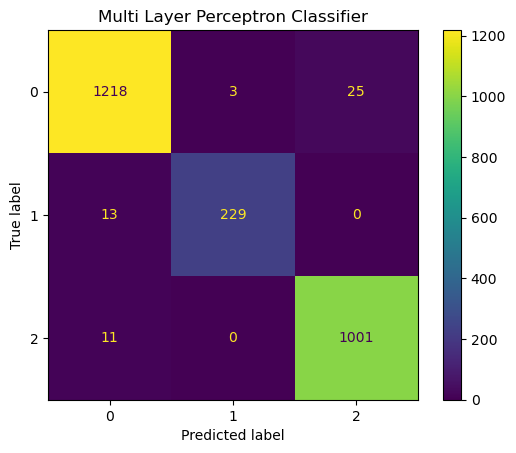

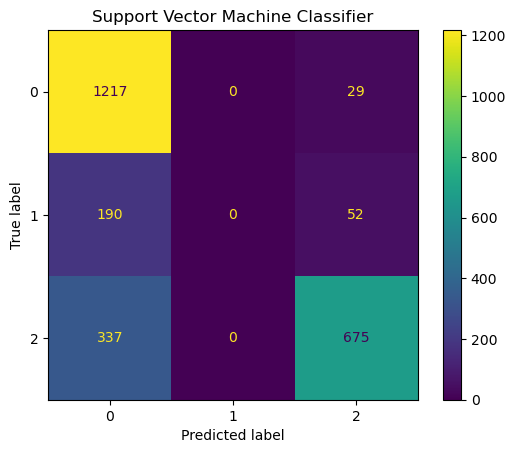

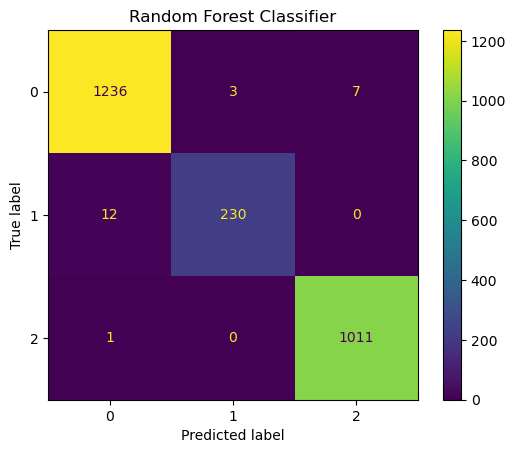

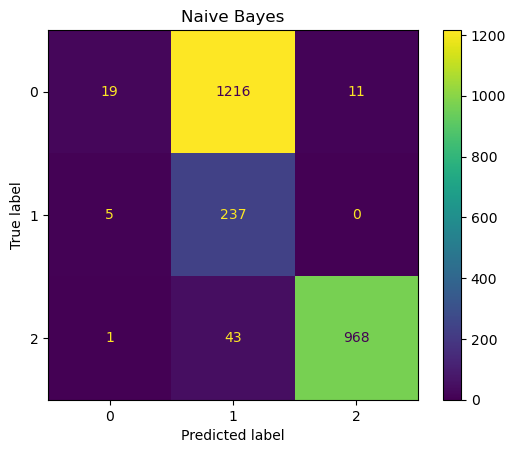

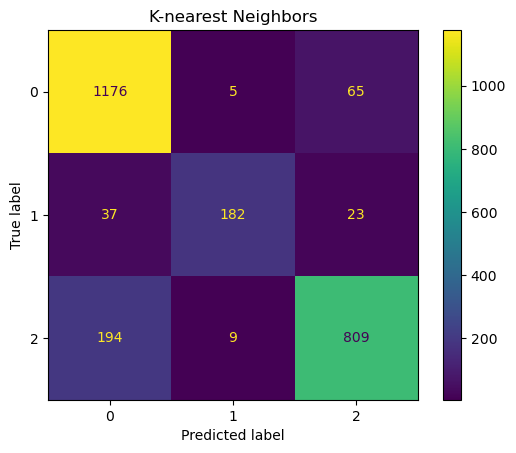

In [459]:
# plot the confusion matrix


disp_MLP = metrics.plot_confusion_matrix(mlp, test_features, test_labels)
disp_MLP.ax_.set_title('Multi Layer Perceptron Classifier')

disp_svc = metrics.plot_confusion_matrix(SVC_clf, test_features, test_labels)
disp_svc.ax_.set_title('Support Vector Machine Classifier')

disp_rf = metrics.plot_confusion_matrix(rf_clf, test_features, test_labels)
disp_rf.ax_.set_title('Random Forest Classifier')

nb_disp = metrics.plot_confusion_matrix(gnb, test_features, test_labels)
nb_disp.ax_.set_title('Naive Bayes')

knn_disp = metrics.plot_confusion_matrix(knn_clf, test_features, test_labels)
knn_disp.ax_.set_title('K-nearest Neighbors')

**Task: Comment on what you see the best classifier is likely to be (1 point).** You can also comment on the misclassification and confusion rates.

The best likely classifier is the Multi Layer Perceptron classifer becuase it has the highest rates among the labels versus other models.

### 2.4.a K Fold Cross Validation
We will now perform k fold cross valdiation for the classifiers. We use the function ``cross_val_score`` on each ewstimator, on the training set, with 10 folds, and use accuracy as a score metric.

**Task: perform the cross validation over K folds, output the mean and standard deviation of the accuracy (3 points)**

In [460]:
from sklearn.model_selection import cross_val_score

cross_knn = cross_val_score(knn_clf, train_features, train_labels, cv=10)

cross_mlp = cross_val_score(mlp, train_features, train_labels, cv=10)

cross_svc = cross_val_score(SVC_clf, train_features, train_labels, cv=10)

cross_nb = cross_val_score(gnb, train_features, train_labels, cv=10)

cross_rf = cross_val_score(rf_clf, train_features, train_labels, cv=10)


print("K-nearest neighbors Mean:", cross_knn.mean(),"Standard Deviation:", cross_knn.std())

print("Multi Layer Perceptron Mean:", cross_mlp.mean(),"Standard Deviation:", cross_mlp.std())

print("Support Vector Machine Mean:", cross_svc.mean(),"Standard Deviation:", cross_svc.std())

print("Gaussian Naive Bayes:", cross_nb.mean(),"Standard Deviation:", cross_nb.std())

print("Random Forest Mean:", cross_rf.mean(),"Standard Deviation:", cross_rf.std())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

K-nearest neighbors Mean: 0.8773333333333333 Standard Deviation: 0.008305286134611985
Multi Layer Perceptron Mean: 0.9805333333333334 Standard Deviation: 0.0051016337252557395
Support Vector Machine Mean: 0.7334666666666666 Standard Deviation: 0.010127191120937733
Gaussian Naive Bayes: 0.9705333333333334 Standard Deviation: 0.007338180216435742
Random Forest Mean: 0.9869333333333333 Standard Deviation: 0.00472534537244515


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


**Task: Which method won the Xval test (1 point) ?**

see the cell below

The winning model is the random forest model!

### 2.4.c And the winner is ...

Let's compare the results. 
**Task: Create a pandas dataframe with all of the performance metrics, including the results from K-fold cross validation. (2 points)**

In [461]:
# create data frame
results = pd.DataFrame({
    'Model': ['KNN', 'Naive Bayes', 'Random Forest', 'SVC','ANN'],
    'Accuracy': [accuracy_k,accuracy_nb,accuracy_rf,accuracy_svm,accuracy_mlp,],
    'Precision': [precision_k, precision_nb, precision_rf, precision_svm, precision_mlp],
    'Recall': [recall_k, recall_nb, recall_rf, recall_svm, recall_mlp],
    'Fscore': [fscore_k, fscore_nb, fscore_rf, fscore_svm, fscore_mlp],
    'Kfold_accuracy_mean': [cross_knn.mean(), cross_nb.mean(), cross_rf.mean(), cross_svc.mean(), cross_mlp.mean()],
    'Kfold_accuracy_std': [cross_knn.std(), cross_nb.std(), cross_rf.std(), cross_svc.std(), cross_mlp.std()]})
# sort values by the Fscore with the greatest value first.

results.sort_values('Fscore', ascending=False)

,Model,Accuracy,Precision,Recall,Fscore,Kfold_accuracy_mean,Kfold_accuracy_std
2,Random Forest,0.990800,0.990228,0.983911,0.986984,0.986933,0.004725
4,ANN,0.979200,0.980493,0.973720,0.976990,0.980533,0.005102
1,Naive Bayes,0.971515,0.964407,0.947880,0.955507,0.970533,0.007338
0,KNN,0.866800,0.882233,0.843443,0.858734,0.877333,0.008305
3,SVC,0.756800,0.597821,0.617538,0.595852,0.733467,0.010127


**Task: Comment on the accuracy and performance and choose a winner. (1 point)**

see the cell below

<!-- answer here -->






## 3 Summary (4 points)

### 3.1 Feature Importance using Random Forest Classifier

Decision Trees have the unique property of being able to order features by their ability to split between the classes. If some features dominate over other in the predictive power of classes, one can further reduce the dimension of the features for additional analysis. The vector of feature importance is the module ``rfc.feature_importances_``, sorted with ascending importance. Store the vector of importance .

**Task: plot a bar plot using the function ``matplotlib.pyplot.bar``. (2 points)**

In [467]:
# answer
feature_list = sky_df.drop('class',axis=1)
# vector of importance
importances = list(rf_clf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];


Variable: redshift             Importance: 0.44
Variable: plate                Importance: 0.17
Variable: mjd                  Importance: 0.13
Variable: i                    Importance: 0.06
Variable: z                    Importance: 0.06
Variable: g                    Importance: 0.04
Variable: r                    Importance: 0.04
Variable: u                    Importance: 0.03
Variable: ra                   Importance: 0.01
Variable: dec                  Importance: 0.01
Variable: field                Importance: 0.01
Variable: fiberid              Importance: 0.01
Variable: run                  Importance: 0.0
Variable: rerun                Importance: 0.0
Variable: camcol               Importance: 0.0


In [478]:
feature_list = []
importance_list = []
for var, impor in feature_importances:
    feature_list.append(var)
    importance_list.append(impor)

In [479]:
feature_list

['redshift',
 'plate',
 'mjd',
 'i',
 'z',
 'g',
 'r',
 'u',
 'ra',
 'dec',
 'field',
 'fiberid',
 'run',
 'rerun',
 'camcol']

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 [Text(0, 0, 'redshift'),
  Text(1, 0, 'plate'),
  Text(2, 0, 'mjd'),
  Text(3, 0, 'i'),
  Text(4, 0, 'z'),
  Text(5, 0, 'g'),
  Text(6, 0, 'r'),
  Text(7, 0, 'u'),
  Text(8, 0, 'ra'),
  Text(9, 0, 'dec'),
  Text(10, 0, 'field'),
  Text(11, 0, 'fiberid'),
  Text(12, 0, 'run'),
  Text(13, 0, 'rerun'),
  Text(14, 0, 'camcol')])

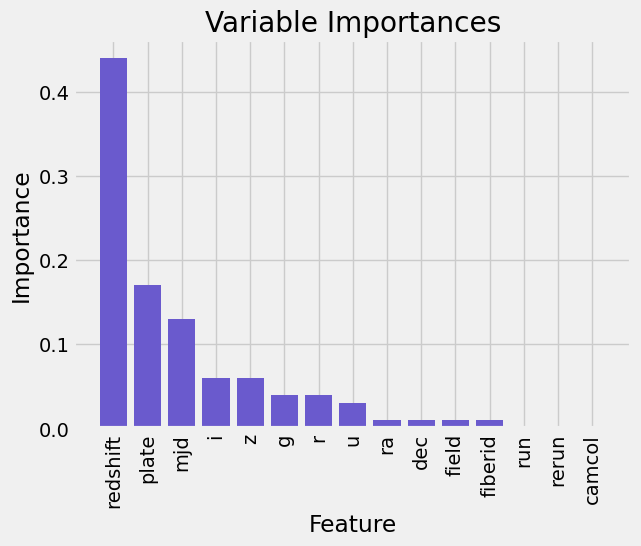

In [484]:
import matplotlib.pyplot as plt
%matplotlib inline
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances[:4])))
# Make a bar chart
c = 'slateblue'
plt.bar(feature_list, importance_list, orientation = 'vertical', color = c)
# Tick labels for x axis
#plt.xticks(feature_list, , rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Feature'); plt.title('Variable Importances'); plt.xticks(rotation=90)

**Task: What are the top three features (1 point)?**

The top three features are redshift, plate, and mjd

<!-- answer -->

In this notebook, you have learned that redshift was the best predictor of what object you are observing. Now, did you actualy need to do this all to find this out? Probably not if you were an astrophysicist! But hey, we are not. So great job!

**Task: Briefly comment on what you have learned (1 point)**

I have learned to do correlations with features and to use PCA to reduce the number of dimensions making our models more efficent and accurate. I also learned how to quicjly implement several ml models, all of which may perform better or worse depending on the dataset. Additionally I learned how to implement K Fold Cross Validation which is used to estimate the skill of a model on test data.  Additionally that RF has a handy feature importance function that can help us determine which features are most influencial on the dataset.

## Bonus questions (5 points)


Perform hyperparameter tuning and ensemble learning to improve on the classification performance.

In [ ]:
# answer below

<!-- answer -->